<div style="font-style: italic; text-align: center;" markdown="1">
<br>
<br>


# Haskell eXchange - 2021

## Multi-dimensional Arrays That Do Not Exit

### Alexey Kuleshevich

<br>
<br>
</div>

* `massiv` - https://github.com/lehins/massiv
* Slides - https://github.com/lehins/talks/tree/master/2021-HaskellExchange

In [1]:
import qualified Data.Vector as V
import qualified Data.Vector.Primitive as VP

-- [_,_,_]
--  \ \ \
--  \ \ [5,6]
--  \ [3,4]
--  [1,2]
makeNestedV :: VP.Prim e => (Int, Int) -> ((Int, Int) -> e) -> V.Vector (VP.Vector e)
makeNestedV (m, n) f = V.generate m $ \i -> VP.generate n $ \j -> f (i, j)

-- [1,2,3,4,5,6]
makeMatrixVP :: VP.Prim e => (Int, Int) -> ((Int, Int) -> e) -> VP.Vector e
makeMatrixVP (m, n) f = VP.generate (m * n) $ \ k -> f (k `quotRem` m)

In [2]:
:set -XTypeApplications
import IHaskell.Display

gauss :: Floating a => a -> a -> a
gauss x y = exp (- (x ^ (2 :: Int) + y ^ (2 :: Int)))

latex "$f(x, y) = e^{-(x^2 + y^2)}$"

Prelude.mapM_ print $ 
  makeNestedV @Float (5, 5) $ \(i, j) -> 
    gauss (fromIntegral j - 2) (fromIntegral i - 2)

[3.3546262e-4,6.737947e-3,1.831564e-2,6.737947e-3,3.3546262e-4]
[6.737947e-3,0.13533528,0.36787945,0.13533528,6.737947e-3]
[1.831564e-2,0.36787945,1.0,0.36787945,1.831564e-2]
[6.737947e-3,0.13533528,0.36787945,0.13533528,6.737947e-3]
[3.3546262e-4,6.737947e-3,1.831564e-2,6.737947e-3,3.3546262e-4]

In [3]:
:set -XBangPatterns
import Control.Monad.ST
import qualified Data.Vector.Generic as VG
import qualified Data.Vector.Generic.Mutable as VGM

makeMatrixMutV :: VG.Vector v e => (Int, Int) -> ((Int, Int) -> e) -> v e
makeMatrixMutV (m, n) f =
  runST $ do
    mutArr <- VGM.unsafeNew (m * n)
    let fillRows i
          | i < m = do
            let fillColumns j
                  | j < n = do
                    VGM.unsafeWrite mutArr (n * i + j) $! f (i, j)
                    fillColumns (j + 1)
                  | otherwise = pure ()
            fillColumns 0
            fillRows (i + 1)
          | otherwise = pure ()
    fillRows 0
    VG.unsafeFreeze mutArr

In [4]:
import Helpers
-- Creates a 2001 x 2001 matrix filled with the gaussian function 
-- centered in the middle of array
showBench "common" 170

Here should be benchmarks

## Immutable

```haskell
data family Array r ix e :: Type

type Vector r e = Array r Ix1 e
type Matrix r e = Array r Ix2 e
```

## Mutable

```haskell
data family MArray s r ix e :: Type

type MVector s r e = MArray s r Ix1 e
type MMatrix s r e = MArray s r Ix2 e
```

## Manifest Arrays (interface)

```haskell
class (Strategy r, Size r) => Source r e where
  unsafeIndex       :: Index ix =>
    Array r ix e -> ix -> e
  ....
```

```haskell
class Source r e => Manifest r e where
  unsafeNew         :: (Index ix, PrimMonad m) =>
    Sz ix -> m (MArray (PrimState m) r ix e)
  unsafeThaw        :: (Index ix, PrimMonad m) =>
    Array r ix e -> m (MArray (PrimState m) r ix e)
  unsafeFreeze      :: (Index ix, PrimMonad m) =>
    Comp -> MArray (PrimState m) r ix e -> m (Array r ix e)
  unsafeLinearRead  :: (Index ix, PrimMonad m) =>
    MArray (PrimState m) r ix e -> Int -> m e
  unsafeLinearWrite :: (Index ix, PrimMonad m) =>
    MArray (PrimState m) r ix e -> Int -> e -> m ()
  ....
```

## Manifest Arrays (instances)

* Unboxed representations:
  * `P` - uses `Prim` instance from `primitive` (`Int`, `Word`, `Char`, etc.)
  * `U` - uses `Unbox` instance from `vector` (`Bool`, tuples, custom types)
  * `S` - uses `Storable` instance from `base`. Pinned memory only.
* Boxed representations:
  * `BL` - elements are evaluated lazily.
  * `B` - elements are in Weak-head Normal Form (WHNF)
  * `BN` - elements are in Normal Form (NF). Requires `NFData` instance

In [5]:
import Data.Massiv.Array as A
import Data.Massiv.Array.Unsafe as A

makeMatrixS :: Manifest r e => Sz2 -> (Ix2 -> e) -> Matrix r e
makeMatrixS sz@(Sz2 m n) f =
  runST $ do
    mutArr <- unsafeNew sz
    loopM_ 0 (< m) (+ 1) $ \i ->
      loopM_ 0 (< n) (+ 1) $ \j ->
        unsafeWrite mutArr (i :. j) $ f (i :. j)
    unsafeFreeze Seq mutArr

showBench "vector-massiv" 120

Here should be benchmarks

In [6]:
import Data.IORef
import Control.Monad (when)
import Control.Concurrent
import System.IO.Unsafe

makeMatrixWithFork :: Manifest r a => Sz2 -> (Ix2 -> a) -> Matrix r a
makeMatrixWithFork sz@(Sz2 m n) f =
  unsafePerformIO $ do
    mutArr <- unsafeNew sz
    when (m > 0) $ do
      mRef <- newIORef m
      lock <- newEmptyMVar
      loopM_ 0 (< m) (+ 1) $ \i ->
        forkIO $ do
          loopM_ 0 (< n) (+ 1) $ \j ->
            unsafeWrite mutArr (i :. j) $ f (i :. j)
          done <- atomicModifyIORef' mRef (\c -> (c - 1, c == 1))
          when done $ putMVar lock ()
      readMVar lock
    unsafeFreeze Seq mutArr
    
showBench "massiv-seq-vs-fork" 120

Here should be benchmarks

In [7]:
import Control.Concurrent.Async (forConcurrently_)

makeMatrixWithAsync :: Manifest r a => Sz2 -> (Ix2 -> a) -> Matrix r a
makeMatrixWithAsync sz@(Sz2 m n) f =
  unsafePerformIO $ do
    mutArr <- unsafeNew sz
    forConcurrently_ [0 .. m - 1] $ \i ->
      loopM_ 0 (< n) (+ 1) $ \j ->
        unsafeWrite mutArr (i :. j) $ f (i :. j)
    unsafeFreeze Seq mutArr
    
showBench "massiv-seq-vs-fork-vs-async" 150

Here should be benchmarks

In [8]:
import UnliftIO.Async (pooledForConcurrently_)

makeMatrixWithPooled :: Manifest r a => Sz2 -> (Ix2 -> a) -> Matrix r a
makeMatrixWithPooled sz@(Sz2 m n) f =
  unsafePerformIO $ do
    mutArr <- unsafeNew sz
    pooledForConcurrently_ [0 .. m - 1] $ \i ->
      loopM_ 0 (< n) (+ 1) $ \j ->
        unsafeWrite mutArr (i :. j) $ f (i :. j)
    unsafeFreeze Seq mutArr
    
showBench "massiv-seq-vs-fork-vs-async-vs-pooled" 160

Here should be benchmarks

In [9]:
import Control.Scheduler

makeMatrix :: Manifest r a => Comp -> Sz Ix2 -> (Ix2 -> a) -> Matrix r a
makeMatrix comp sz@(Sz2 m n) f =
  unsafePerformIO $ do
    mutArr <- unsafeNew sz
    withScheduler_ comp $ \scheduler ->
      loopM_ 0 (< m) (+ 1) $ \i ->
        scheduleWork_ scheduler $
          loopM_ 0 (< n) (+ 1) $ \j -> 
            unsafeWrite mutArr (i :. j) $ f (i :. j)
    unsafeFreeze comp mutArr

showBench "massiv-seq-vs-par-vs-pooled" 130

Here should be benchmarks

In [10]:
import Control.Parallel (par)
import Control.Parallel.Strategies (parTraversable, rpar, runEval)

makeNestedV ::
  VP.Prim e => (Int, Int) -> ((Int, Int) -> e) -> V.Vector (VP.Vector e)
makeNestedV (m, n) f = V.generate m $ \i -> VP.generate n $ \j -> f (i, j)

makeNestedVrpar ::
  VP.Prim e => (Int, Int) -> ((Int, Int) -> e) -> V.Vector (VP.Vector e)
makeNestedVrpar sz f = runEval $ parTraversable rpar $ makeNestedV sz f

makeNestedVpar ::
  VP.Prim e => (Int, Int) -> ((Int, Int) -> e) -> V.Vector (VP.Vector e)
makeNestedVpar (m, n) f = V.unfoldrExactN m inner 0
  where
    inner i =
      let v = VP.generate n $ \j -> f (i, j)
       in v `par` (v, i + 1)

showBench "massiv-seq-vs-par-vs-rpar" 180

--   SPARKS: 382191 (376992 converted, 0 overflowed, 0 dud, 4767 GC'd, 432 fizzled)

Here should be benchmarks

3.142242659935647

3.141592653589793

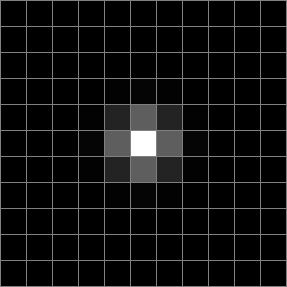

In [11]:
latex "$\\int_{-\\infty}^\\infty\\int_{-\\infty}^\\infty e^{-(x^2 + y^2)} \\, dxdy = \\pi$"

let ga :: Matrix P Double
    ga = makeArray Seq (Sz (11 :. 11)) $ \(i :. j) ->
           gauss (fromIntegral j - 5) (fromIntegral i - 5)
A.sum ga
pi
showZoomedMatrix ga

In [12]:
midpointRule ::
     (Integral a, Fractional t) => (t -> t -> t) -> a -> t -> t -> Ix2 -> t
midpointRule f n x0 y0 (i :. j) =
  let x0' = x0 - 0.5
      y0' = y0 - 0.5
      nf = fromIntegral n
      delta = 1 / nf
      delta2 = delta * delta
      x = x0' + fromIntegral j / nf
      y = y0' + fromIntegral i / nf
   in delta2 * f (x + delta / 2) (y + delta / 2)

In [13]:
integrate :: Fractional e => (e -> e -> e) -> e -> e -> e
integrate f x0 y0 =
  let n = 100
   in A.sum $ makeArrayR D Seq (Sz2 n n) $ midpointRule f n x0 y0

A.sum $ 
  makeArrayR D Par (Sz (11 :. 11)) $ \(i :. j) -> 
    integrate @Double gauss (fromIntegral j - 5) (fromIntegral i - 5)
pi

3.14159265358974

3.141592653589793

In [14]:
:set -XTypeFamilies

data Pull = Pull -- Corresponds to `D` in massiv
data instance Array Pull ix e =
  PullArray { pullComp  :: Comp -- ^ Computation strategy
            , pullSize  :: Sz ix -- ^ Size of array
            , pullIndex :: ix -> e -- ^ Function to produce a value from an index
            }

In [15]:
:set -XFlexibleInstances
:set -XMultiParamTypeClasses

instance Size Pull where
  size = pullSize

instance Strategy Pull where
  getComp = pullComp
  setComp comp arr = arr { pullComp = comp }

instance Source Pull e where
  unsafeIndex = pullIndex

toPullArray :: (Index ix, Source r e) => Array r ix e -> Array Pull ix e
toPullArray arr = PullArray (getComp arr) (size arr) (unsafeIndex arr)

In [16]:
A.sum $ 
  PullArray Par (Sz (11 :. 11)) $ \(i :. j) -> 
    integrate @Double gauss (fromIntegral j - 5) (fromIntegral i - 5)

3.14159265358974

In [17]:
import Control.Scheduler

sumMatrix :: (Source r e, Num e) => Matrix r e -> e
sumMatrix mat = 
  unsafePerformIO $ do
    let Sz (m :. n) = size mat
    xs <- withScheduler (getComp mat) $ \scheduler ->
      loopM_ 0 (< m) (+ 1) $ \i ->
        scheduleWork scheduler $ 
          loopM 0 (< n) (+ 1) 0 $ \ j acc -> 
            pure $! acc + unsafeIndex mat (i :. j)
    pure $! Prelude.sum xs

sumMatrix $
  PullArray Par (Sz (11 :. 11)) $ \(i :. j) -> 
    integrate @Double gauss (fromIntegral j - 5) (fromIntegral i - 5)

3.1415926535897407

In [18]:
hflip :: Source r e => Matrix r e -> Matrix Pull e
hflip mat = PullArray (getComp mat) sz $ \(i :. j) -> unsafeIndex mat (i :. n - j - 1)
  where sz@(Sz (_ :. n)) = size mat

In [19]:
leftToRightPull :: (Source r1 e, Source r2 e) => 
    Matrix r1 e -> Matrix r2 e -> Matrix Pull e
leftToRightPull mat1 mat2
  | m1 /= m2 = error "Heights of two matrices must agree."
  | otherwise = 
    PullArray (getComp mat1 <> getComp mat2) (Sz2 m1 (n1 + n2)) $ \(i :. j) ->
      if j < n1
      then unsafeIndex mat1 (i :. j)
      else unsafeIndex mat2 (i :. (j - n1))
  where
    Sz2 m1 n1 = size mat1
    Sz2 m2 n2 = size mat2

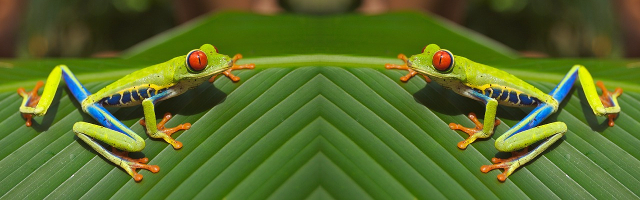

In [20]:
:set -XDataKinds
import Data.Massiv.Array.IO

frog <- readImageAuto "frog.jpg" :: IO (Matrix S (Pixel (SRGB 'Linear) Float))
showImage $ computeAs S $ delay $ leftToRightPull (hflip frog) frog

### Computable arrays
```haskell
class (Strategy r, Shape r ix) => Load r ix e where
  makeArray :: Comp -> Sz ix -> (ix -> e) -> Array r ix e
  iterArrayLinearST_ :: Scheduler s () -- ^ A scheduler that we can use
                     -> Array r ix e -- ^ Array to iterate
                     -> (Int -> e -> ST s ()) -- Unsafe linear write
                     -> ST s ()
```

In [21]:
instance Index ix => Shape Pull ix
instance ix ~ Ix2 => Load Pull ix e where
  makeArray = PullArray
  iterArrayLinearST_ scheduler arr uWrite = do
    let sz@(Sz (m :. n)) = size arr
    loopM_ 0 (< m) (+ 1) $ \i ->
      scheduleWork_ scheduler $
        loopM_ 0 (< n) (+ 1) $ \j -> 
          uWrite (toLinearIndex sz (i :. j)) $ unsafeIndex arr (i :. j)

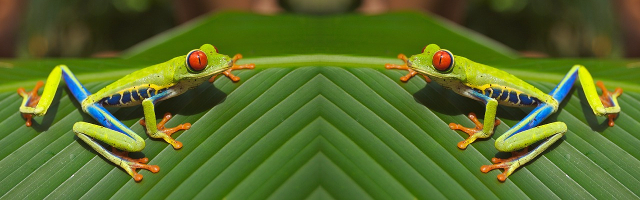

In [22]:
computeArray :: (Manifest r e, Size r', Load r' ix e) => Array r' ix e -> Array r ix e
computeArray arr =
  unsafePerformIO $ do
    marr <- unsafeNew (size arr)
    withScheduler_ (getComp arr) $ \scheduler ->
      stToIO (iterArrayLinearST_ scheduler arr (unsafeLinearWrite marr))
    unsafeFreeze (getComp arr) marr
  
showImage $ computeArray @S $ leftToRightPull (hflip frog) frog

In [23]:
:set -XRankNTypes

data Push = Push -- Corresponds to `DL` in `massiv`

data instance Array Push ix e = PushArray
  { pushComp :: Comp
  , pushSize :: Sz ix
  , pushLoad :: forall s.
                Scheduler s () -- ^ Scheduler that can be used for parallelization
             -> (Int -> e -> ST s ()) -- ^ Linear element writing action
             -> ST s ()
  }

In [24]:
instance Size Push where
  size = pushSize

instance Strategy Push where
  getComp = pushComp
  setComp c a = a { pushComp = c}

-- Can't do:
-- instance Source Push e where
--  unsafeIndex = ..?

In [25]:
instance Index ix => Shape Push ix
instance ix ~ Ix2 => Load Push ix e where
  makeArray comp sz f = toPushArray (PullArray comp sz f)
  iterArrayLinearST_ scheduler arr = pushLoad arr scheduler

toPushArray :: Load r ix e => Array r ix e -> Array Push ix e
toPushArray arr = 
  PushArray (getComp arr) (outerSize arr) $ \scheduler -> 
    iterArrayLinearST_ scheduler arr

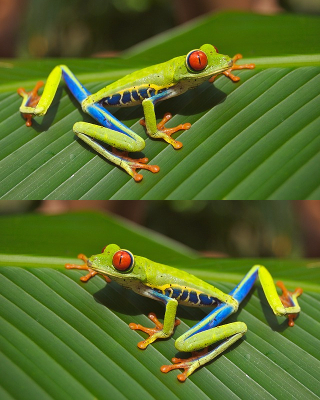

In [26]:
:set -XFlexibleContexts

topToBottomPush :: (Size r1, Load r1 Ix2 e, Size r2, Load r2 Ix2 e)
    => Matrix r1 e -> Matrix r2 e -> Matrix Push e
topToBottomPush a1 a2
  | n1 /= n2 = error "Widths of two matrices must agree."
  | otherwise =
    PushArray (getComp a1 <> getComp a2) sz $ \ scheduler uLinearWrite -> do
      scheduleWork_ scheduler $
        iterArrayLinearST_ scheduler a1 uLinearWrite
      scheduleWork_ scheduler $
        iterArrayLinearST_ scheduler a2 (\i -> uLinearWrite (i + t1))
  where
    t1 = totalElem (size a1)
    sz = Sz2 (m1 + m2) n1
    Sz2 m1 n1 = size a1
    Sz2 m2 n2 = size a2

showImage $ computeArray @S $ topToBottomPush (hflip frog) frog

## Windowed array

```haskell
data DW = DW

data instance Array DW ix e = DWArray { dwArray :: Array D ix e
                                      , dwWindow :: Maybe (Window ix e)
                                      }

data Window ix e = Window { windowStart     :: ix
                          , windowSize      :: Sz ix
                          , windowIndex     :: ix -> e
                          , windowUnrollIx2 :: Maybe Int
                          }
```

In [27]:
lifeRules :: Word8 -> Word8 -> Word8
lifeRules 0 3 = 1
lifeRules 1 x | x == 2 || x == 3 = 1
lifeRules _ _ = 0

lifeStencil :: Stencil Ix2 Word8 Word8
lifeStencil = makeStencil (Sz (3 :. 3)) (1 :. 1) $ \ f ->
  lifeRules (f (0 :. 0))
  (f (-1 :. -1) + f (-1 :. 0) + f (-1 :. 1) +
   f ( 0 :. -1) +               f ( 0 :. 1) +
   f ( 1 :. -1) + f ( 1 :. 0) + f ( 1 :. 1))

lifeStep :: Matrix S Word8 -> Matrix S Word8
lifeStep = compute . A.mapStencil Wrap lifeStencil

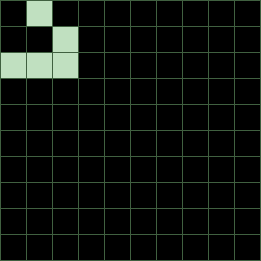

In [28]:
import Control.Monad (guard)
import qualified Data.List.NonEmpty as NE

glider :: Matrix S Word8
glider = fromLists' Seq [ [0, 1, 0]
                        , [0, 0, 1]
                        , [1, 1, 1] ]

initLife :: Sz2 -> Matrix S Word8
initLife sz = compute $ insertWindow (A.replicate Par sz 0) $ 
                Window 0 (size glider) (index' glider) Nothing

runGameOfLife :: Int -> Matrix S Word8 -> NE.NonEmpty (Matrix S Word8)
runGameOfLife n initStep =
  NE.unfoldr (\(s, i) -> (s, guard (i > 0) >> Just (lifeStep s, i - 1))) (initStep, n)

showAnimation 10 $ runGameOfLife 39 $ initLife (Sz (10 :. 10))

In [29]:
g = makeArrayR P Seq (Sz (5 :. 5)) $ \(i :. j) -> 
      integrate @Float gauss (fromIntegral j - 2) (fromIntegral i - 2)
let kernel = A.map (/ A.sum g) g
kernel

Array D Seq (Sz (5 :. 5))
  [ [ 2.8056404e-4, 3.7334564e-3, 8.721989e-3, 3.7334568e-3, 2.8056404e-4 ]
  , [ 3.733447e-3, 4.9680933e-2, 0.11606331, 4.9680933e-2, 3.7334482e-3 ]
  , [ 8.722032e-3, 0.11606352, 0.27114448, 0.11606351, 8.722029e-3 ]
  , [ 3.7334554e-3, 4.968091e-2, 0.11606348, 4.9680915e-2, 3.7334543e-3 ]
  , [ 2.805635e-4, 3.7334478e-3, 8.722029e-3, 3.733449e-3, 2.8056343e-4 ]
  ]

mapStencil :: forall ix r e a. (Index ix, Manifest r e) => Border e -> Stencil ix e a -> Array r ix e -> Array DW ix a

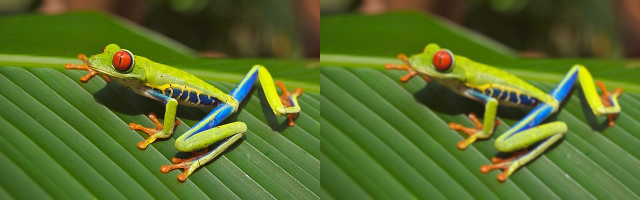

In [30]:
let gaussianStencil :: Stencil Ix2 (Pixel (SRGB 'Linear) Float)
                                   (Pixel (SRGB 'Linear) Float)
    gaussianStencil = 
      makeConvolutionStencilFromKernel (A.computeAs S (A.map pure kernel))

frog <- readImageAuto "frog.jpg" :: IO (Matrix S (Pixel (SRGB 'Linear) Float))
let frogBlurry = computeAs S (mapStencil Edge gaussianStencil frog)
showImage $ computeAs S $ leftToRightPull frog frogBlurry

What about common operations like: `filter`, `mapMaybe`, `unfoldr`?

Any vector that we don't know the size of until we compute all of its element is really just a stream of values.

```haskell
data DS = DS

newtype instance Array DS Ix1 e = DSArray
  { dsArray :: Steps Id e
  }

data Steps m e = Steps
  { stepsStream :: Stream m e
  , stepsSize   :: LengthHint
  }

data Stream m a = forall s. Stream (s -> m (Step s a)) s

data Step s a where
  Yield :: a -> s -> Step s a
  Skip  :: s -> Step s a
  Done  :: Step s a
```

In [31]:
stake 10 $ sfilter even $ siterate succ 10

Array DS Seq (Sz1 10)
  [ 10, 12, 14, 16, 18, 20, 22, 24, 26, 28 ]